In [1]:
#load dependancies
import json,os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import umap
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter
from sklearn.metrics import plot_confusion_matrix


In [2]:
#Change this path to the downloaded data 
path2base=''

# Supervised behaviral classification
can be used to extract behaviors of interest from the pose predictions

you can use muvilab https://github.com/ale152/muvilab (or something different) to label your videos with behaviors of interest
See muvilab github for manual how to use

We then calculate a bunch of variables based on keypoints predictions (keypoint-keypoint distances, keypoint-ground, keypoint velocity, keypoint vel stft etc.)
those variables can be created from standard rat skel using pose_to_vars.py from FreiPose docker
python pose_to_vars.py config/model_rat.cfg.json %s --local --vel --vel_local --stft --body_angles --body_angle_vel --plane --plane_vel --plane_file %s --save --file_out_name %s

Those Variables(924 dimentions) are then embedded into UMAP space (2 dims) to reduce the dimentionallity

Then a SVM classifier is trained on those embedding with labels obtained from muvilab.

in this example we provide some already trained UMAP and SVM model

Most likely in our case you would need to train own embeddings and SVC to adapt it to data at hand

In [3]:
# load example test session variables
from other_utils import ReadVarsFile
Vars,Vars_names = ReadVarsFile(path2base)
print(Vars.shape)
print(np.random.choice(Vars_names,10))

(52157, 924)
['stft_rat_local_head_Paw Back Left Tip_dist_11'
 'rat_local_head_Eye Left_y' 'plane_dist_vel_Ear Right'
 'stft_rat_local_head_Nose_dist_13'
 'stft_rat_local_head_Paw Front Left_dist_2'
 'stft_rat_local_head_Paw Front Right_dist_5'
 'stft_plane_Paw Back Right Tip_31' 'stft_rat_local_head_Eye Left_dist_9'
 'stft_plane_Paw Front Left_0' 'stft_rat_local_head_Nose_dist_13']


In [26]:
from other_utils import ReadMuviAnno
labels = ReadMuviAnno(path2base,len(Vars))

In [5]:
# load pretrained UMAP and SVM models    
with open(path2base + "Beh_class/method_neighbors101.pkl",'rb') as fi:
    umap=pickle.load(fi)
with open(path2base + "Beh_class/SVM.pkl",'rb') as fi:
    svm=pickle.load(fi) 

In [19]:
#those are heavy steps, expect some computation time

scaler = StandardScaler() 
Vars = gaussian_filter(Vars,(1,0)) # filter
Vars = scaler.fit_transform(Vars)  # scale each variable input to have 0 mean an 1 variance
X = umap.transform(Vars) # UMAP dimentionality reduction takes some time... reduces to 2 dimentions
preds = svm.predict(X)


In [20]:
#Sort some labels

labels = np.array(labels)
X=X[labels>=0] # remove unclear behaviors
labels=labels[labels>=0]
X=X[labels!=5] # remove turning (was initially included but then not used)
preds[labels!=5] = -1 # for preds we set turning to unclear
labels=labels[labels!=5]

In [21]:
#Check score on the test session
print('SVM achieved %0.3f'%svm.score(X,labels))

SVM achieved 0.837


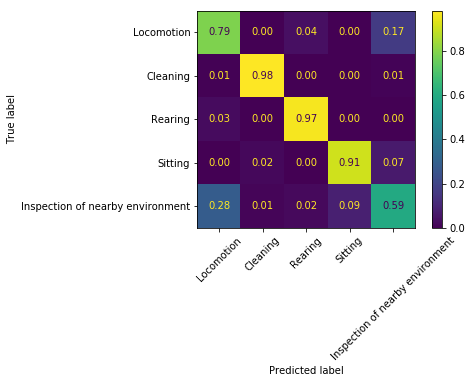

In [30]:
#plot confusion matrix
list_of_labels=['Locomotion', 'Cleaning', 'Rearing', 'Sitting', 'Inspection of nearby environment']
f=plot_confusion_matrix(svm, X, labels, labels=None, sample_weight=None, normalize='true', display_labels=list_of_labels, include_values=True, xticks_rotation=45, values_format='.2f', cmap='viridis', ax=None)